In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
physicaldevices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physicaldevices[0],True)
except:
    pass

In [3]:
import gdown

In [4]:
def load_video(path:str) ->List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames - mean), tf.float32)/std

In [5]:
vocab = [i for i in  "1234567890qwertyuiopasdfghjklzxcvbnm'?! "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert = True)

print(f"vocabulary is :{char_to_num.get_vocabulary()}"  f"(size ={char_to_num.vocabulary_size()})")

vocabulary is :['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p', 'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm', "'", '?', '!', ' '](size =41)


In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens = []
    for l in lines:
        l = l.split()
        if l[2] != 'sil':
            tokens= [*tokens,' ',l[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding = 'UTF-8'),(-1)))[1:] 

In [8]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [9]:
testing_path = '.\\data\\s1\\bbal6n.mpg'

In [10]:
frames , alignments = load_data(tf.convert_to_tensor(testing_path))
print(frames)
print(alignments)

tf.Tensor(
[[[[ 1.460374  ]
   [ 1.460374  ]
   [ 1.4209044 ]
   ...
   [ 0.15787826]
   [ 0.19734783]
   [ 0.07893913]]

  [[ 1.460374  ]
   [ 1.460374  ]
   [ 1.4209044 ]
   ...
   [ 0.15787826]
   [ 0.07893913]
   [ 0.03946957]]

  [[ 1.4209044 ]
   [ 1.4209044 ]
   [ 1.3814349 ]
   ...
   [ 0.07893913]
   [ 0.07893913]
   [ 0.07893913]]

  ...

  [[ 0.9472696 ]
   [ 0.9472696 ]
   [ 0.9472696 ]
   ...
   [ 9.946331  ]
   [ 9.867392  ]
   [ 9.867392  ]]

  [[ 0.9472696 ]
   [ 0.9472696 ]
   [ 0.9472696 ]
   ...
   [ 9.906861  ]
   [ 9.867392  ]
   [ 9.867392  ]]

  [[ 0.9472696 ]
   [ 0.9472696 ]
   [ 0.9472696 ]
   ...
   [ 9.906861  ]
   [ 9.867392  ]
   [ 9.867392  ]]]


 [[[ 1.4209044 ]
   [ 1.4209044 ]
   [ 1.3419653 ]
   ...
   [ 0.19734783]
   [ 0.1184087 ]
   [ 0.15787826]]

  [[ 1.4209044 ]
   [ 1.4209044 ]
   [ 1.3419653 ]
   ...
   [ 0.2368174 ]
   [ 0.        ]
   [ 0.03946957]]

  [[ 1.3419653 ]
   [ 1.3419653 ]
   [ 1.3024957 ]
   ...
   [ 0.1184087 ]
   [ 0.15787826]


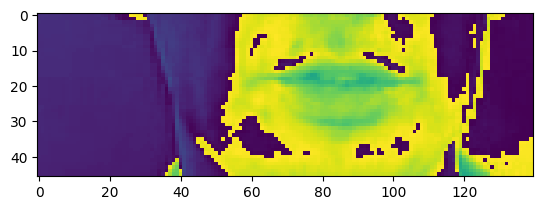

In [11]:
plt.imshow(frames[32])

In [12]:
num_to_char(alignments.numpy())

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [13]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [14]:
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
        result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
        return result

In [15]:
data = tf.data.Dataset.list_files('.\\data\\s1\\*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [16]:

sample = data.as_numpy_iterator()
# print(sample.next())

In [17]:
val = sample.next();val[0]

array([[[[[1.4136448 ],
          [1.4136448 ],
          [1.4136448 ],
          ...,
          [0.15282646],
          [0.07641323],
          [0.03820661]],

         [[1.4136448 ],
          [1.4136448 ],
          [1.4136448 ],
          ...,
          [0.15282646],
          [0.07641323],
          [0.03820661]],

         [[1.3754382 ],
          [1.3754382 ],
          [1.3754382 ],
          ...,
          [0.07641323],
          [0.03820661],
          [0.03820661]],

         ...,

         [[0.9551654 ],
          [0.9551654 ],
          [0.9551654 ],
          ...,
          [9.589861  ],
          [9.589861  ],
          [9.589861  ]],

         [[0.9169588 ],
          [0.9169588 ],
          [0.9169588 ],
          ...,
          [9.551654  ],
          [9.551654  ],
          [9.551654  ]],

         [[0.9169588 ],
          [0.9169588 ],
          [0.9169588 ],
          ...,
          [9.551654  ],
          [9.551654  ],
          [9.551654  ]]],


        [[[1.3372

In [18]:
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv,duration=100)

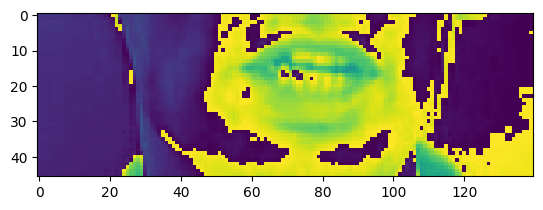

In [19]:
plt.imshow(val[0][0][35])

In [20]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white in t one again'>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [22]:
data.as_numpy_iterator().next()[0].shape

(2, 75, 46, 140, 1)

In [23]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [25]:
p1 = model.predict(val[0])

1/1 [==============================] - 14s 14s/step


In [26]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(p1[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666666666666666666666666666666666666666666666666666666999999999999999999'>

In [27]:
model.input_shape

(None, 75, 46, 140, 1)

In [28]:
model.output_shape

(None, 75, 42)

In [29]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [30]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [31]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [33]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [34]:
schedule_callback = LearningRateScheduler(scheduler)

In [35]:
example_callback = ProduceExample(test)

In [36]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

1/1 [==============================] - 2s 2s/steps - loss: 85.23
Original: place red at c eight please
Prediction: le e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in x six please
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1016s 2s/step - loss: 85.2330 - val_loss: 71.2041 - lr: 1.0000e-04


In [37]:
model.load_weights('models/checkpoint')

In [38]:
test_data = test.as_numpy_iterator()

In [39]:
sample = test_data.next(); sample[0]

array([[[[[1.2758075 ],
          [1.2758075 ],
          [1.3144684 ],
          ...,
          [0.        ],
          [9.858513  ],
          [9.858513  ]],

         [[1.2758075 ],
          [1.2758075 ],
          [1.3144684 ],
          ...,
          [0.        ],
          [9.858513  ],
          [9.858513  ]],

         [[1.3531291 ],
          [1.3531291 ],
          [1.3144684 ],
          ...,
          [0.03866084],
          [0.03866084],
          [0.03866084]],

         ...,

         [[0.92786   ],
          [0.92786   ],
          [0.92786   ],
          ...,
          [9.549226  ],
          [9.549226  ],
          [9.549226  ]],

         [[0.92786   ],
          [0.92786   ],
          [0.92786   ],
          ...,
          [9.549226  ],
          [9.549226  ],
          [9.549226  ]],

         [[0.92786   ],
          [0.92786   ],
          [0.92786   ],
          ...,
          [9.549226  ],
          [9.549226  ],
          [9.549226  ]]],


        [[[1.2758

In [40]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 582ms/step


In [41]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in c nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red in k five again'>]

In [42]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [43]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'le '>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'le '>]

In [44]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [45]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [46]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 608ms/step


In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [48]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'le '>]